Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Выводы и рассуждения получились содержательными, их было интересно читать.
* Радует, что тебе удалось разобраться с техникой бутстрапа.
* Отлично, что риск убытков посчитан верно.
* Над этим проектом нужно будет еще немного поработать. Однако, изменения не должны занять много времени.
* В работе я оставил несколько советов. Буду рад, если ты учтешь их.
* С радостью отвечу на твои вопросы, если они есть. Лучше всего их собрать в следующей ячейке. Жду новую версию проекта.

### <font color='orange'>Общее впечатление (ревью 2)</font>
* После исправлений проект улучшился и теперь он может быть зачтен.
* Для удобства все новые комментарии обозначены фразой "ревью 2".
* Удачи в дальнейшем обучении и следующих работах!

# Выбор локации для скважины

Мы работаем в добывающей компании «ГлавРосГосНефть». Постараемся решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from numpy.random import RandomState
state = RandomState(12345)

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
# Загрузка данных
geo_1 = pd.read_csv('/datasets/geo_data_0.csv')
geo_2 = pd.read_csv('/datasets/geo_data_1.csv')
geo_3 = pd.read_csv('/datasets/geo_data_2.csv')

Изучим каждый датасет по очереди на полноту и адекватность с учетом описания представленных данных:

<b>Описание данных</b>

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей)

#### Датасет региона geo_1

In [3]:
print(geo_1.head())
print()
print(geo_1.describe())
print()
print(geo_1.info())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5

Данные на первый взгляд выглядят корректно и полно. Отрицательные значения признаков f предпочитаю не трогать: это могут быть некие координаты, где отрицательные значения допустимы.

In [4]:
# Проверка на дубликаты по скважинам
geo_1['id'].duplicated().value_counts()

False    99990
True        10
Name: id, dtype: int64

Выявлены подозрительные дубликаты данных по уникальным скважинам. Вероятно, для данных скважин анализ проводился повторно. Поскольку число дубликатов незначительно и вряд ли сильно повлияет на обучение будущей модели, предлагаю их оставить для единообразия форм датасетов по каждому региону.

#### Датасет региона geo_2

In [5]:
print(geo_2.head())
print()
print(geo_2.describe())
print()
print(geo_2.info())

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data colu

Аналогично первому региону данные выглядят единообразно и адекватно.

In [6]:
# Проверка на дубликаты по скважинам
geo_2['id'].duplicated().value_counts()

False    99996
True         4
Name: id, dtype: int64

Для второго региона данные по уникальным скважинам тоже незначительно дублируются. Опять-таки оставим дубликаты ввиду их малого числа.

#### Датасет региона geo_3

In [7]:
print(geo_3.head())
print()
print(geo_3.describe())
print()
print(geo_3.info())

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5

Данные выглядят полно и корректно. Дополнительной предобработки не требуют.

In [8]:
# Проверка на дубликаты по скважинам
geo_3['id'].duplicated().value_counts()

False    99996
True         4
Name: id, dtype: int64

Снова выявлены совпадения уникальных id скважин. Их совсем мало - оставим для полноты выборки данных.

Проверим признаки по регионам на корреляционные связи с помощью тепловых карт

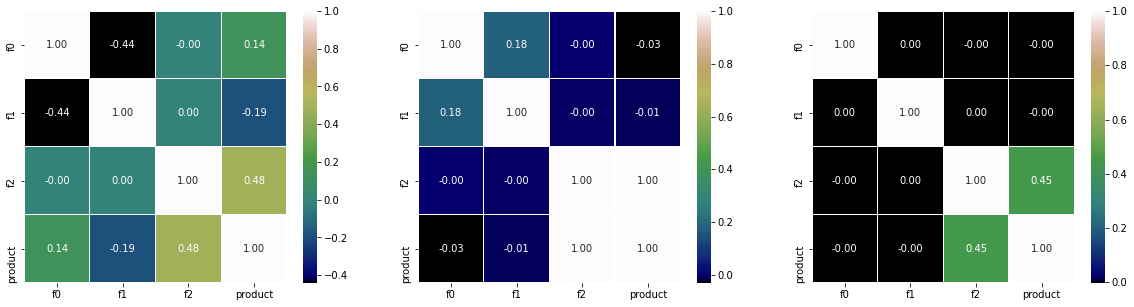

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
for i, j in zip([geo_1, geo_2, geo_3], range(3)):    
    sns.heatmap(i.corr(),annot=True, linewidths=.1, ax=ax[j], fmt= '.2f', cmap='gist_earth')

Для региона geo_1 нет ни одной сильной связи признаков в датасете. Самую сильную зависимость демонстрирует связь целевого признака product с f2 (корреляция равна 0.48) и отрицательная корреляция целевого признака product с f1 (корреляция равна -0.44).

Для региона geo_2 обнаружена прямая зависимость целевого признака product от признака f2 с корреляцией, равной единице. 

Для региона geo_3 также наблюдается более сильная зависимость целевого признака product от f2, хоть она и относительно слабая (корреляция равна 0.45).

#### Общие выводы по регионам geo_1, geo_2, geo_3

* проведен предварительный анализ датасетов по трем регионам geo_1, geo_2, geo_3. Данные выглядят адекватно, без явных аномалий - глубокой предобработки данных не требуется.
* в каждом датасете выявлено несколько дубликатов данных для одного и того же уникального id скважины. Принято решение оставить их ввиду пренебрежимо малого количества и отсутствия влияния на обучение будущей модели.
* анализ корреляции данных по трем регионам показал отсутствие сильных связей между данными. При этом в регионе geo_2 наблюдается прямая связь между целевым признаком product и признаком f2.

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены и осмотрены корректно. Радует, что корреляции были визуализированы.
</div>

## Обучение и проверка модели

По условиям задачи для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

In [10]:
model = LinearRegression()

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25. Введем функцию для проведения данной манипуляции по трем регионам. В рамках вводимой функции также обучим модель и сделаем предсказания на валидационной выборке. 

In [11]:
def get_answer(data):
    features = data.drop(['id', 'product'], axis = 1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = (
        train_test_split(features, target, test_size=.25, random_state=state))
    model.fit(features_train, target_train)
    answer = pd.Series(model.predict(features_valid))
    return answer, target_valid

Сохраним предсказания и правильные ответы на валидационной выборке по трем регионам.

In [12]:
geo_1_predicted, geo_1_target = get_answer(geo_1)
geo_2_predicted, geo_2_target = get_answer(geo_2)
geo_3_predicted, geo_3_target = get_answer(geo_3)

Введем функцию для расчета среднего запаса предсказанного сырья и RMSE модели по каждому региону.

In [13]:
def mean_product_rmse(answers, predictions):
    mse = mean_squared_error(answers, predictions)
    print('Cредний запас предсказанного сырья составляет {:.3f}, а RMSE модели {:.3f}'.format(predictions.mean(), mse ** 0.5))

In [14]:
# Данные для региона geo_1
mean_product_rmse(geo_1_target, geo_1_predicted)

Cредний запас предсказанного сырья составляет 92.593, а RMSE модели 37.579


In [15]:
# Данные для региона geo_2
mean_product_rmse(geo_2_target, geo_2_predicted)

Cредний запас предсказанного сырья составляет 68.770, а RMSE модели 0.890


In [16]:
# Данные для региона geo_3
mean_product_rmse(geo_3_target, geo_3_predicted)

Cредний запас предсказанного сырья составляет 95.088, а RMSE модели 39.958


In [17]:
geo_table = pd.DataFrame(
    data=[[37.579, 0.890, 39.958], [92.593, 68.770, 95.088]], 
    index=['RMSE', 'Средний запас'], 
    columns=['geo_1','geo_2','geo_3'])
geo_table

,geo_1,geo_2,geo_3
RMSE,37.579,0.89,39.958
Средний запас,92.593,68.77,95.088


<b>Вывод:</b>

* Самое высокое качество модели показано для данных региона geo_2, где метрика RMSE показывает минимальное значение. Вероятно, поведение модели определяет тот самый высокий коэффициент корреляции целевого признака и признака F1.
* Для регионов geo_1 и geo_3 средний предсказанный запас сырья превышает 90000 бареллей, что серьезно выше данных по региону geo_2. Однако значение RMSE для работы модели по данным регионам оказалось значительным.

<div class="alert alert-block alert-success">
<b>Успех:</b> Модели обучены корректно. Радует, что ты активно используешь функции. Это помогает избежать дублирования кода, а значит уменьшает вероятность совершить ошибку/опечатку!
</div>

## Подготовка к расчёту прибыли

Сохраним ключевые значения для расчётов в отдельных переменных.

In [18]:
# Бюджет на разработку скважин в регионе в рублях
BUDGET = 10000000000

# Количество скважин для бурения в регионе
WELLS_NUMBER = 200

# Бюджет на одну скважину в регионе
BUDGET_PER_WELL = BUDGET / WELLS_NUMBER

# Доход с одной единицы продукта в рублях
REVENUE = 450000

# Максимальная доля убытков
LOSS_RISK = 0.025

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [19]:
# Достаточный объем сырья для безубыточной разработки новой скважины
min_product = BUDGET_PER_WELL / REVENUE
print('Точка безубыточности {:.3f} тысяч баррелей.'.format(min_product))

Точка безубыточности 111.111 тысяч баррелей.


Сравним предсказанный объём сырья со средним запасом в каждом регионе.

In [20]:
product_mean = pd.DataFrame(
    data=[[geo_1_target.mean(), geo_2_target.mean(), geo_3_target.mean()], 
          [geo_1_predicted.mean(), geo_2_predicted.mean(), geo_3_predicted.mean()]], 
    index=['Истинный средний запас', 'Предсказанный средний запас'], 
    columns=['geo_1','geo_2','geo_3'])
product_mean

,geo_1,geo_2,geo_3
Истинный средний запас,92.078597,68.771624,94.748959
Предсказанный средний запас,92.592568,68.769951,95.087528


Полученные значения ни в одном из регионов не достигают точки безубыточности (111.111 тыс. баррелей). Однако по условиям задачи, при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Посчитаем прибыль по 200 скважинам каждого региона, где идет наибольшая выработка сырья.

<div class="alert alert-block alert-info">

<b>Совет: </b> В названиях константных переменных лучше использовать только БОЛЬШИЕ буквы. Это соглашение между программистами: https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html#id29 .
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> Точка безубыточности найдена верно, сравнение проведено!
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Спасибо большое за совет с наименованием констант. Этот пункт я упустила и теперь буду аккуратнее при назначении таких имен. Ввела caps lock уже постфактум, прошу прощения за неудобство.
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Спасибо!
</div>

In [21]:
# Функция для расчета прибыли по выбранным скважинам и предсказаниям модели
def well_profit(target, probabilities):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities).reset_index(drop=True)
    sorted = probabilities.sort_values(ascending=False)
    selected = target[sorted.index][:WELLS_NUMBER]
    return ((REVENUE * selected.sum()) - BUDGET) / 1000000000

<div class="alert alert-block alert-info">
<b>Совет: </b> Эту функцию лучше было бы назвать profit, так как revenue – это выручка.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены подсказанные изменения: функция переименована в корректном наименовании. Спасибо за логичное и заботливое замечание :)
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> ОК.
</div>

In [22]:
# Прибыль по 200 скважинам региона geo_1 в млрд. рублей
round(well_profit(geo_1_target, geo_1_predicted), 3)

3.321

In [23]:
# Прибыль по 200 скважинам региона geo_2 в млрд. рублей
round(well_profit(geo_2_target, geo_2_predicted), 3)

2.415

In [24]:
# Прибыль по 200 скважинам региона geo_3 в млрд. рублей
round(well_profit(geo_3_target, geo_3_predicted), 3)

2.54

<b>Вывод:</b>
* Наибольшую прибыль для полученного объема сырья дают скважины первого региона geo_1 в размере 3.3 миллиардов рублей.

## Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли для каждого региона. Введем для этого новую функцию.

In [37]:
def bootstrap(target, predictions):
    
    # Значения выручек для 1000 выборок
    revenues = []
    
    # Итерации по 1000 выборок
    for i in range(1000):
        # Сбрасываем у целевого признака валидацационной выборки индексы и случайным образом выбираем нужное количество скважин
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        # Из предсказанных значений выбираем строки, соответствующие отобранным строкам в целевом признаке
        prob_subsample = predictions[target_subsample.index]
        # Cчитаем выручку для отобранных строк
        selected = well_profit(target_subsample, prob_subsample)
        revenues.append(selected)

    revenues = pd.Series(revenues)
    #confidence_interval = st.t.interval(0.95, len(revenues)-1, revenues.mean(), revenues.sem())

    lower = round(revenues.quantile(.025), 3)
    upper = round(revenues.quantile(.975), 3)
    confidence_interval = (lower, upper)
    
    print('Средняя выручка: {:.3f} млрд. рублей'.format(revenues.mean()))
    print('Квантиль 2.5%: {:.3f}'.format(revenues.quantile(LOSS_RISK)))
    print('Доверительный интервал:', confidence_interval)
    print('Риск убытка: {:.1f}%'.format((revenues < 0).mean()*100))

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Для подсчета доверительного интервала стоит использовать метод квантилей, так как мы реализуем технику бутстрап, а не st.t.interval.
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> Риск найден очень элегантно.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены изменения: доверительный интервал пересчитан методом квантилей. Спасибо за меткое замечание.
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Теперь все верно, молодец!
</div>

In [38]:
# Показатели для региона geo_1
bootstrap(geo_1_target, geo_1_predicted)

Средняя выручка: 0.371 млрд. рублей
Квантиль 2.5%: -0.166
Доверительный интервал: (-0.166, 0.903)
Риск убытка: 7.8%


In [39]:
# Показатели для региона geo_2
bootstrap(geo_2_target, geo_2_predicted)

Средняя выручка: 0.450 млрд. рублей
Квантиль 2.5%: 0.060
Доверительный интервал: (0.06, 0.842)
Риск убытка: 1.0%


In [40]:
# Показатели для региона geo_3
bootstrap(geo_3_target, geo_3_predicted)

Средняя выручка: 0.348 млрд. рублей
Квантиль 2.5%: -0.180
Доверительный интервал: (-0.18, 0.858)
Риск убытка: 9.0%


<b>Вывод:</b>

* Минимальный уровень прогнозируемого убытка демонстрирует регион geo_2. При этом и добыча в данном регионе потенциально может принести наибольшую прибыль.
* Регионы geo_1 и geo_3 показывают высокую вероятность убытка (7.8% и 9.0% соответственно), превышающую заданный показатель 2.5%. При этом 95%-ый доверительный интервал также хорошо иллюстрирует, что левая граница для регионов geo_1 и geo_3 принимает отрицательное значение, то есть более 2.5% выборок показывает убыточность.

## Общий вывод

На основании трех доступных датасетов мы обучили модель линейной регрессии, которая оценивает запас сырья в скважинах для трёх разных регионов.

Рассчитан достаточный объём сырья для безубыточной разработки новой скважины в размере 111.11 тысяч баррелей. Даже если истинные запасы сырья не достигают данного значения (точки безубыточности) ни в одном из регионов, мы берем 200 самых потенциально прибыльных скважин для дальнейшего анализа.

Используя технику bootstrap, мы смоделировали распределение потенциальной прибыли по представленным регионам c учётом доступного бюджета и возможностей для разработки.

Для каждого региона мы определили среднюю прибыль, 95%-й доверительный интервал и риск убытков.

По полученным показателям регионов мы пришли к выводу, что самый оптимальный вариант для разработки скважин - это регион geo_2, поскольку он в меньшей степени сопряжён с рисками (менее заданного порога в 2.5%) и потенциально более прибыльный (средняя выручка порядка 454 млн. рублей).

<div class="alert alert-block alert-success">
<b>Успех:</b> Приятно видеть вывод в коцне преокта. С выбором региона согласен.
</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован